## Manish Mapakshi(015926729)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    roc_auc_score, confusion_matrix, classification_report, plot_roc_curve

import pickle
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
uploaded = files.upload()

Saving dataset_small.csv to dataset_small.csv


In [3]:
data = pd.read_csv("dataset_small.csv")

# Data Preprocessing

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Columns: 112 entries, qty_dot_url to phishing
dtypes: float64(1), int64(111)
memory usage: 50.1 MB


## Using "phishing" feature to find the frequency of both phishing and non-phishing websites value_counts() and countplot() functions

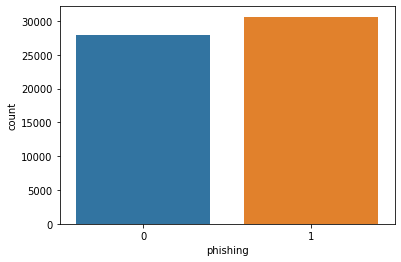

In [5]:
sns.countplot(data['phishing'])

We can clearly infer that the data is imbalanced

## We are using variance threshold for feature selection. Dropping all the 13 columns which doesn't meet the threshold value.

In [6]:
from sklearn.feature_selection import VarianceThreshold
var_thres = VarianceThreshold(threshold=0)
var_thres.fit(data)
var_thres.get_support()
constant_columns = [column for column in data.columns
                    if column not in data.columns[var_thres.get_support()]]
print(len(constant_columns))
constant_columns

13


['qty_slash_domain',
 'qty_questionmark_domain',
 'qty_equal_domain',
 'qty_and_domain',
 'qty_exclamation_domain',
 'qty_space_domain',
 'qty_tilde_domain',
 'qty_comma_domain',
 'qty_plus_domain',
 'qty_asterisk_domain',
 'qty_hashtag_domain',
 'qty_dollar_domain',
 'qty_percent_domain']

In [7]:
data = data.drop(constant_columns,axis=1)

## In the cell below, we are checking the percentage of '-1' values present in each and every feature.

## Checking the columns that has -1 value. -1 value can be considered as a unique category. -1 can be replaced with NaN. We can later find these values using Mean, KNN imputer and MissForest imputer.

In [8]:
## Here we will check the percentage of -1 values present in each feature
## 1 -step make the list of features which has -1 values
missing_data_cols = {}
for col in data.columns:
    values = (data[col].values == -1).sum()
    if not values == 0:
        missing_data_cols[col] = data[col].values
data = data.drop(missing_data_cols,axis= 1)
negative_one_data = pd.DataFrame (missing_data_cols) 

## In the cell below, we are converting the values of '-1' to Nan.

## Checking the columns that has -1 value. -1 value can be considered as a unique category. -1 can be replaced with NaN. We can later find these values using Mean, KNN imputer and MissForest imputer.

In [9]:
def convert_to_nan(data):
    for col in data.columns:
            d = data[col].values
            d = d.astype("float")
            for i in range(len(d)):
                if d[i] == -1.:
                    d[i] = np.nan
            data[col] = d
    return data
negative_one_data = convert_to_nan(negative_one_data)
negative_one_data.isna().sum() 

qty_dot_directory             17507
qty_hyphen_directory          17507
qty_underline_directory       17507
qty_slash_directory           17507
qty_questionmark_directory    17507
                              ...  
qty_ip_resolved                3645
ttl_hostname                   3648
qty_redirects                  5519
url_google_index                  4
domain_google_index               2
Length: 66, dtype: int64

## In the below cell, we are using missing number library to plot missing values. From the figure, we can say that there are a lot of missing params values.

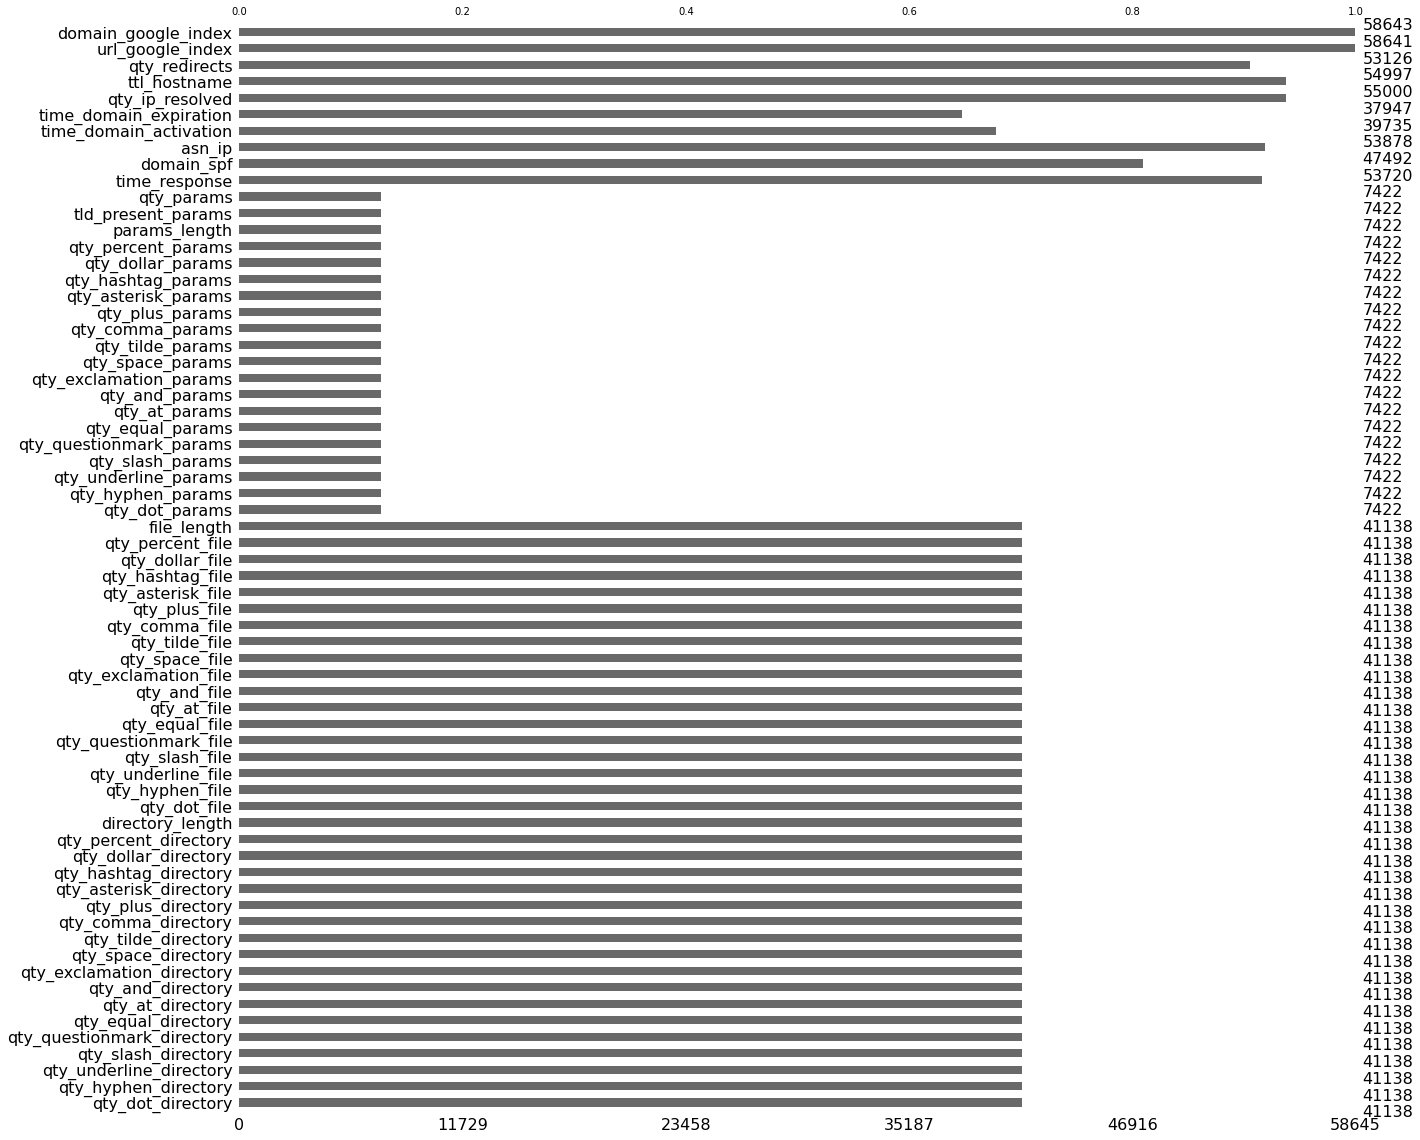

In [10]:
msno.bar(negative_one_data,figsize = (20,20))

## In the cell below, we are plotting a figure to produce heatmap for the missing data.

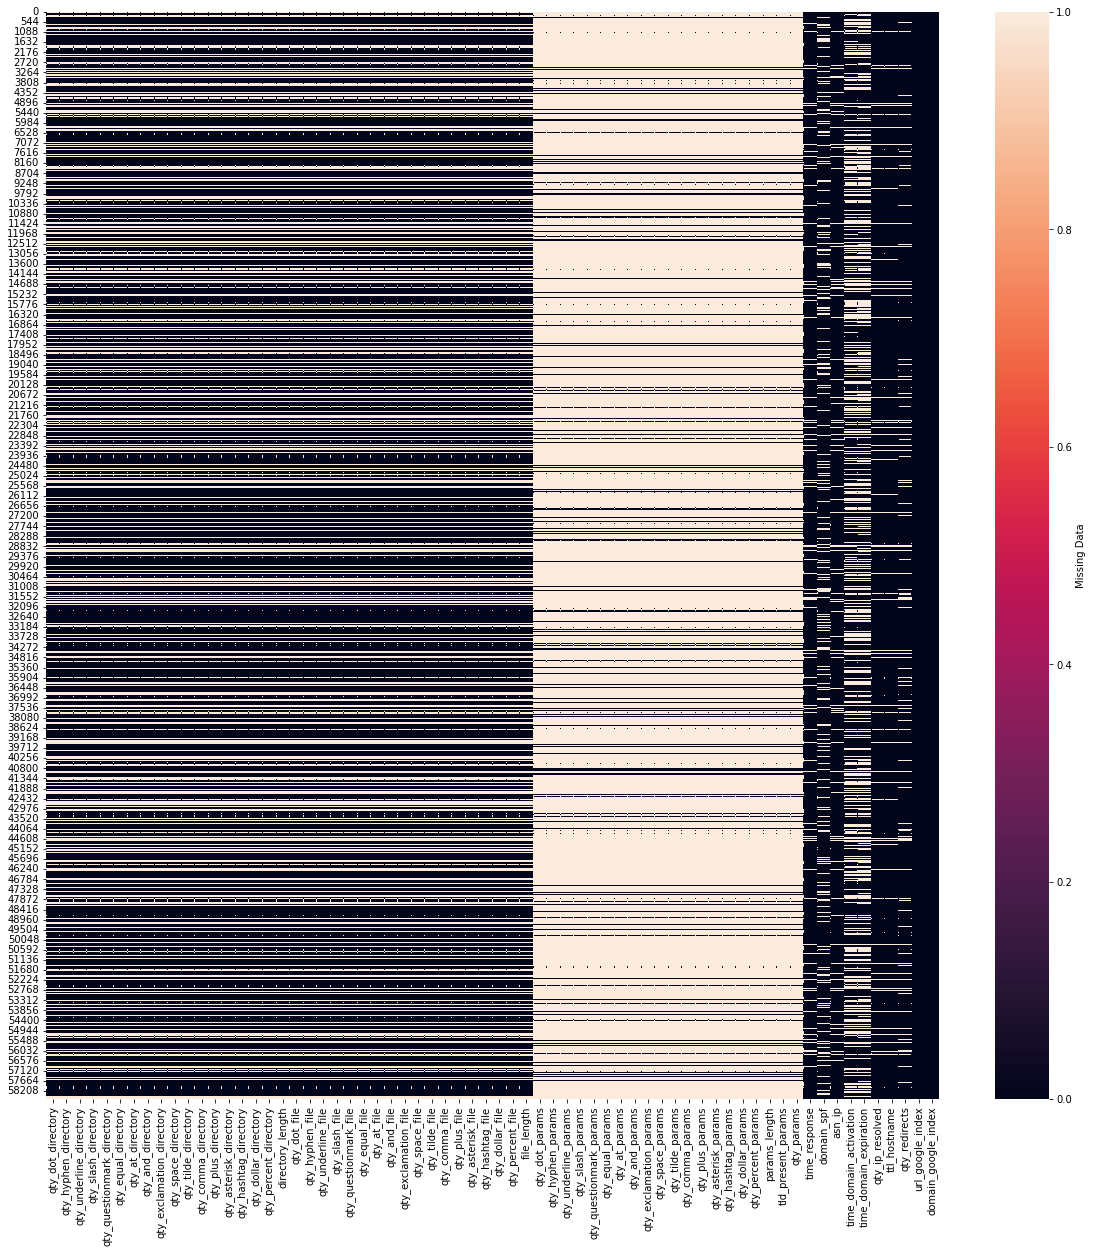

In [11]:
#missing values before imputation
plt.figure(figsize=(20,20))
sns.heatmap(negative_one_data.isna(),cbar_kws={'label':'Missing Data'})

#### As there are so many missing values, we try to drop the param values.  

In [12]:
data.shape

(58645, 33)

In [13]:
features_to_be_removed = ["qty_dot_params", "qty_hyphen_params", "qty_underline_params",
                                   "qty_slash_params", "qty_questionmark_params",
                                   "qty_equal_params", "qty_at_params", "qty_and_params",
                                   "qty_exclamation_params", "qty_space_params", 
                                   "qty_tilde_params", "qty_comma_params", "qty_plus_params", 
                                   "qty_asterisk_params", "qty_hashtag_params", 
                                   "qty_dollar_params", "qty_percent_params", "params_length",
                                   "tld_present_params", "qty_params"]
negative_one_data = negative_one_data.drop(features_to_be_removed,axis=1)

In [14]:
negative_one_data.shape

(58645, 46)

# Sai Gowtham Ande (015246023)


### The main idea of this section is to reduce the number of features and then depict all distribution of data and then remove outliers (if any).Then lastly, we go ahead with the training of algorithm.

In [15]:
frames = [data, negative_one_data]

In [16]:
result_dataFrame = pd.concat(frames,axis = 1)

In [17]:
result_dataFrame.shape

(58645, 79)

Here we try to divide the features into different datasets into six groups 

In [18]:
url_features = ["qty_dot_url",'qty_hyphen_url','qty_underline_url','qty_slash_url',
       'qty_questionmark_url', 'qty_equal_url', 'qty_at_url', 'qty_and_url',
       'qty_exclamation_url', 'qty_space_url', 'qty_tilde_url',
       'qty_comma_url', 'qty_plus_url', 'qty_asterisk_url', 'qty_hashtag_url',
       'qty_dollar_url', 'qty_percent_url', 'qty_tld_url', 'length_url','email_in_url']

In [19]:
domain_features = ['qty_dot_domain', 'qty_hyphen_domain', 'qty_underline_domain',
       'qty_at_domain', 'qty_vowels_domain', 'domain_length', 'domain_in_ip',
       'server_client_domain']

In [20]:
directory_features = ['qty_dot_directory', 'qty_hyphen_directory', 'qty_underline_directory',
       'qty_slash_directory', 'qty_questionmark_directory',
       'qty_equal_directory', 'qty_at_directory', 'qty_and_directory',
       'qty_exclamation_directory', 'qty_space_directory',
       'qty_tilde_directory', 'qty_comma_directory', 'qty_plus_directory',
       'qty_asterisk_directory', 'qty_hashtag_directory',
       'qty_dollar_directory', 'qty_percent_directory', 'directory_length']

In [21]:
file_feature = ['qty_dot_file', 'qty_hyphen_file', 'qty_underline_file',
       'qty_slash_file', 'qty_questionmark_file', 'qty_equal_file',
       'qty_at_file', 'qty_and_file', 'qty_exclamation_file', 'qty_space_file',
       'qty_tilde_file', 'qty_comma_file', 'qty_plus_file',
       'qty_asterisk_file', 'qty_hashtag_file', 'qty_dollar_file',
       'qty_percent_file', 'file_length']

In [22]:
phishing_feature = ['phishing']

In [23]:
external_services = ['time_response', 'domain_spf',
       'asn_ip', 'time_domain_activation', 'time_domain_expiration',
       'qty_ip_resolved', 'ttl_hostname', 'qty_redirects', 'url_google_index',
       'domain_google_index','qty_nameservers',
       'qty_mx_servers', 'tls_ssl_certificate', 'url_shortened']

In [24]:
url_features_df = result_dataFrame[url_features]
domain_features_df = result_dataFrame[domain_features]
directory_features_df = result_dataFrame[directory_features]
file_feature_df = result_dataFrame[file_feature]
phishing_feature_df = result_dataFrame[phishing_feature]
external_feature_df = result_dataFrame[external_services]

In [30]:

X = result_dataFrame.drop('phishing',axis=1)
Y = result_dataFrame['phishing']

In [32]:
for column in X.columns:
     X[column].fillna(X[column].mean(), inplace = True)

In [43]:
X.isnull().sum()

qty_dot_url             0
qty_hyphen_url          0
qty_underline_url       0
qty_slash_url           0
qty_questionmark_url    0
                       ..
qty_ip_resolved         0
ttl_hostname            0
qty_redirects           0
url_google_index        0
domain_google_index     0
Length: 78, dtype: int64

Here we try to reduce the number of features using feature selection models in order to reduce the curse of dimensionality.

In [44]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100)
xgb.fit(X, Y)

XGBClassifier()

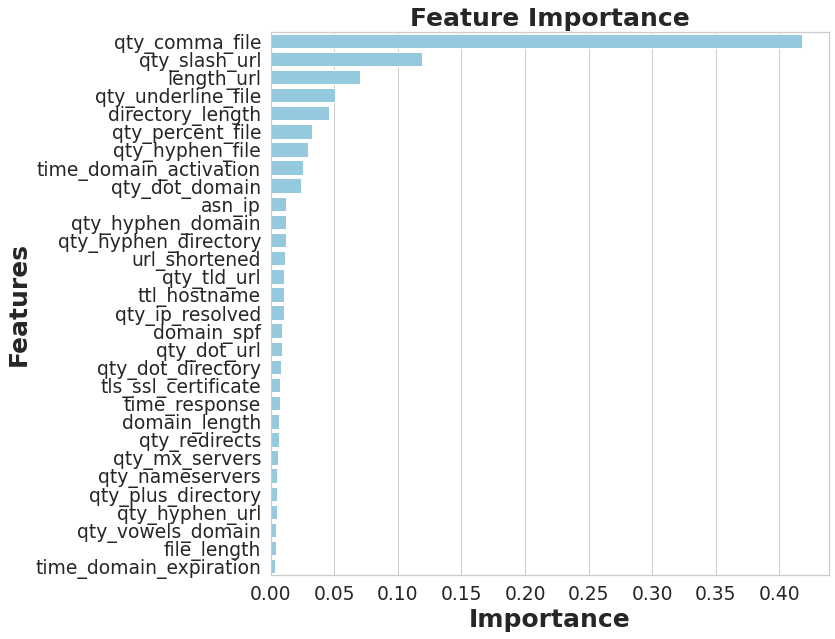

None

In [46]:
import seaborn as sns
feats = {}
for feature, importance in zip(X.columns, xgb.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances = importances.sort_values(by='Importance', ascending=False).nlargest(30, 'Importance')
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.barplot(x=importances['Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())


From the above graph we can clearly say that the first 8 features have a high importance and then the importance became constant.So, we filter out the important features and then continue the analysis.

In [36]:
imp_features_df = X[['qty_comma_file','qty_slash_url','length_url','qty_underline_file','directory_length',
                     'qty_percent_file','qty_hyphen_file','time_domain_activation','qty_dot_domain']]

In [35]:
display(importances)

,Features,Importance
0,qty_comma_file,0.417724
1,qty_slash_url,0.118730
2,length_url,0.070633
3,qty_underline_file,0.050804
4,directory_length,0.045609
5,qty_percent_file,0.032422
6,qty_hyphen_file,0.029125
7,time_domain_activation,0.025802
8,qty_dot_domain,0.024066
9,asn_ip,0.012492


In [47]:
frames = [imp_features_df, Y]
ref_df = pd.concat(frames,axis = 1)

## Now we will do basic analysis to find out if there are outliers in the selected features or not.

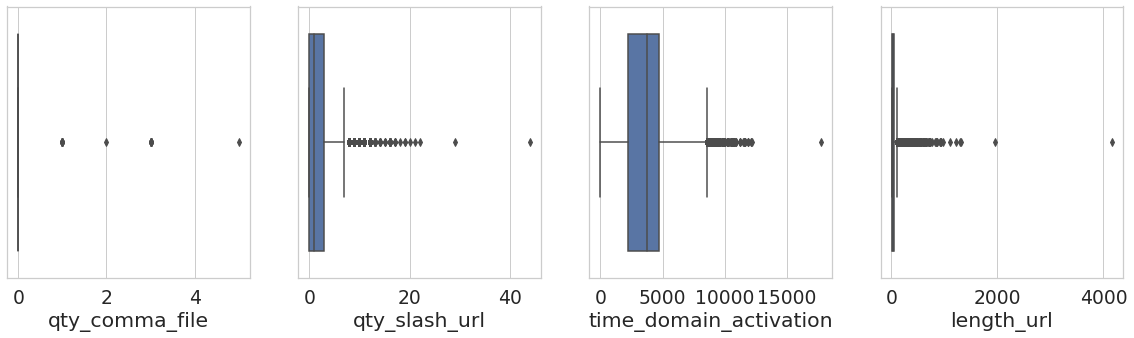

In [78]:
import seaborn as sns
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=True)
fig.set_size_inches(20,5)
sns.boxplot(x=imp_features_df['qty_comma_file'],ax=ax1)
sns.boxplot(x=imp_features_df['qty_slash_url'],ax=ax2)
sns.boxplot(x=imp_features_df['time_domain_activation'],ax=ax3)
sns.boxplot(x=imp_features_df['length_url'],ax=ax4)

## we can clearly see that the outliers exist in the above features like length_url,qty_slash_url. It is also found that the data is distributed normally for the feature time_domian_activation.

## For other features we find out how the data is distrubuted around the median and using violin plot and also how the data is spread

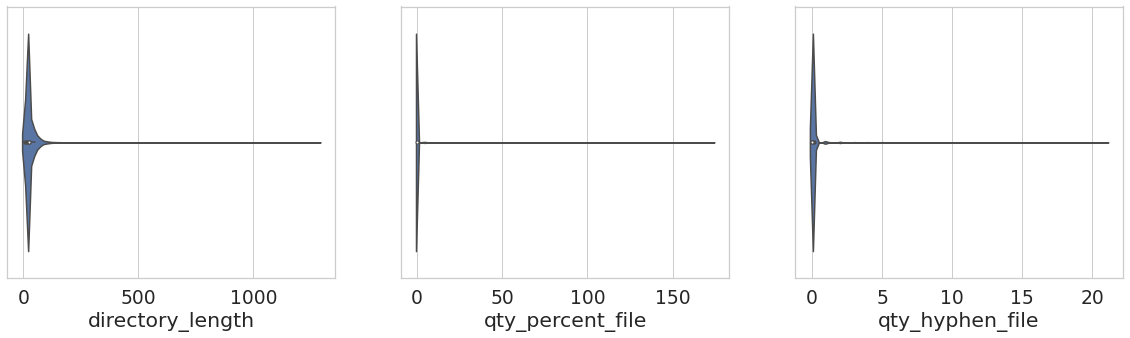

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True)
fig.set_size_inches(20,5)
sns.violinplot(x=imp_features_df['directory_length'],ax=ax1)
sns.violinplot(x=imp_features_df['qty_percent_file'],ax=ax2)
sns.violinplot(x=imp_features_df['qty_hyphen_file'],ax=ax3)

As most of the data for qty_percent_file is lying at zero, but the values are going more than 1000 . So we need to go ahead and remove all the outliers.We also need to remove the outliers for directory_length.

Below we are using the Inter Quartile range to remove all the outliers for the features length_url,directory_length

In [50]:
a = ref_df['length_url']
Q1=a.quantile(0.25)
Q3=a.quantile(0.75)
IQR=Q3-Q1
lowqe_bound=Q1 - 1.5 * IQR
upper_bound=Q3 + 1.5 * IQR
print(lowqe_bound,upper_bound)
percentile25 = ref_df['length_url'].quantile(0.25)
percentile75 = ref_df['length_url'].quantile(0.75)
iqr = percentile75-percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

ref_df[ref_df['length_url'] > upper_limit]
ref_df[ref_df['length_url'] < lower_limit]

ref_df = ref_df[ref_df['length_url'] < upper_limit]

-33.0 103.0


## Below we can clearly see that the outliers have been removed for the features length_url and directory_length

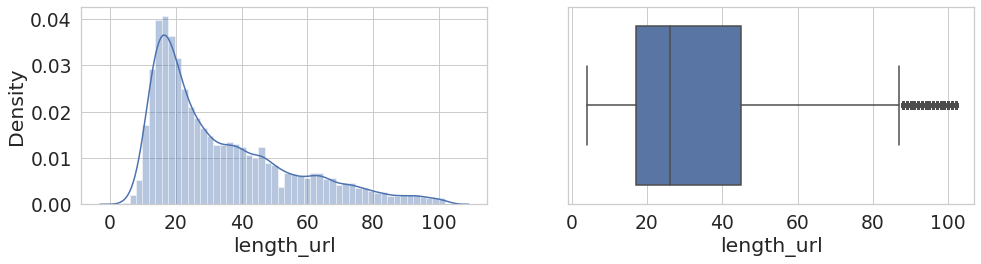

In [51]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(ref_df['length_url'])
plt.subplot(2,2,2)
sns.boxplot(ref_df['length_url'])
plt.show()


-11.827665418834172 46.379442364723616


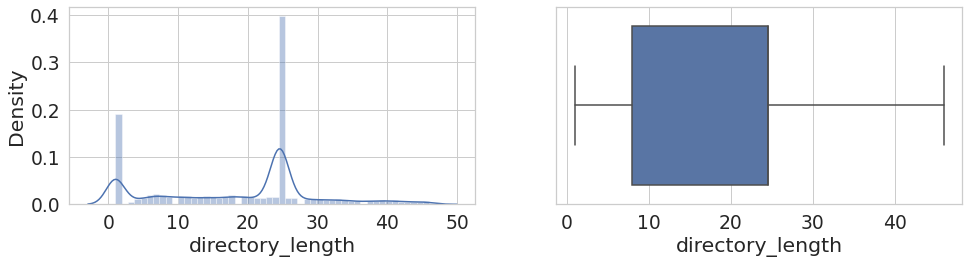

In [52]:
a = ref_df['directory_length']
Q1=a.quantile(0.25)
Q3=a.quantile(0.75)
IQR=Q3-Q1
lowqe_bound=Q1 - 1.5 * IQR
upper_bound=Q3 + 1.5 * IQR
print(lowqe_bound,upper_bound)
percentile25 = ref_df['directory_length'].quantile(0.25)
percentile75 = ref_df['directory_length'].quantile(0.75)
iqr = percentile75-percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

ref_df[ref_df['directory_length'] > upper_limit]
ref_df[ref_df['directory_length'] < lower_limit]

ref_df = ref_df[ref_df['directory_length'] < upper_limit]
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(ref_df['directory_length'])
plt.subplot(2,2,2)
sns.boxplot(ref_df['directory_length'])
plt.show()

Now we will find the correlation between all the features and the target feature.

In [53]:
ref_df.corr()

,qty_comma_file,qty_slash_url,length_url,qty_underline_file,directory_length,qty_percent_file,qty_hyphen_file,time_domain_activation,qty_dot_domain,phishing
qty_comma_file,1.000000,-0.008525,-0.011454,-0.000474,0.020192,0.003171,0.008237,0.007040,-0.014114,-0.023077
qty_slash_url,-0.008525,1.000000,0.730678,-0.050073,0.240532,-0.114427,-0.115372,-0.214254,-0.189529,0.628326
length_url,-0.011454,0.730678,1.000000,0.044975,0.384204,-0.052689,0.017533,-0.162230,0.005249,0.558003
qty_underline_file,-0.000474,-0.050073,0.044975,1.000000,0.127044,0.009741,0.017155,0.036871,0.019322,-0.059268
directory_length,0.020192,0.240532,0.384204,0.127044,1.000000,0.110917,0.178937,0.062040,0.010763,0.053373
qty_percent_file,0.003171,-0.114427,-0.052689,0.009741,0.110917,1.000000,0.023359,0.037263,0.033465,-0.110915
qty_hyphen_file,0.008237,-0.115372,0.017533,0.017155,0.178937,0.023359,1.000000,0.047955,0.025527,-0.078839
time_domain_activation,0.007040,-0.214254,-0.162230,0.036871,0.062040,0.037263,0.047955,1.000000,0.326327,-0.413020
qty_dot_domain,-0.014114,-0.189529,0.005249,0.019322,0.010763,0.033465,0.025527,0.326327,1.000000,-0.270512
phishing,-0.023077,0.628326,0.558003,-0.059268,0.053373,-0.110915,-0.078839,-0.413020,-0.270512,1.000000


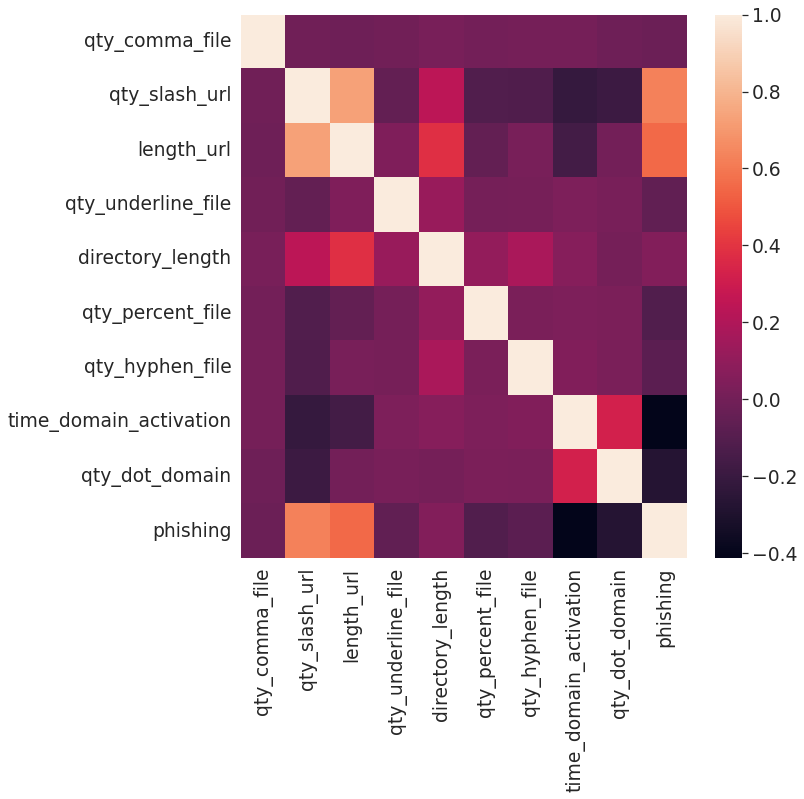

In [54]:
fig = plt.figure(figsize=(8, 6))
fig.set_size_inches(10,10)
sns.heatmap(ref_df.corr())

From the above graph we can clearly say that there a negative correlation between for the feature time_domain_activation and phishing, a positive correlation between features like qty_slash_url and phishing is found

In [55]:
ref_df.head()

,qty_comma_file,qty_slash_url,length_url,qty_underline_file,directory_length,qty_percent_file,qty_hyphen_file,time_domain_activation,qty_dot_domain,phishing
0,0.001215,0,14,0.054256,24.551777,0.080145,0.124654,4927.000000,2,0
1,0.000000,2,38,0.000000,6.000000,0.000000,0.000000,8217.000000,4,0
2,0.000000,1,24,0.000000,1.000000,0.000000,0.000000,258.000000,1,0
3,0.000000,3,38,0.000000,13.000000,0.000000,0.000000,2602.000000,2,1
4,0.000000,4,46,0.000000,27.000000,0.000000,0.000000,3737.372619,1,1


## Below we will try to plot the relation between the length features and the phishing feature.

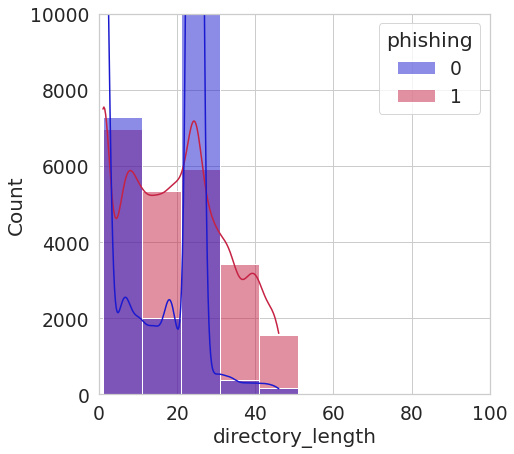

In [80]:
colors = ["#1B1AD0","#C52244"]
plt.figure(figsize=(7,7))
sns.histplot(data=ref_df, x="directory_length", hue = "phishing",binwidth=10, kde=True, palette=sns.color_palette(colors))
plt.ylim(0,10000)
plt.xlim(0, 100)
plt.xlabel('directory_length', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.show()

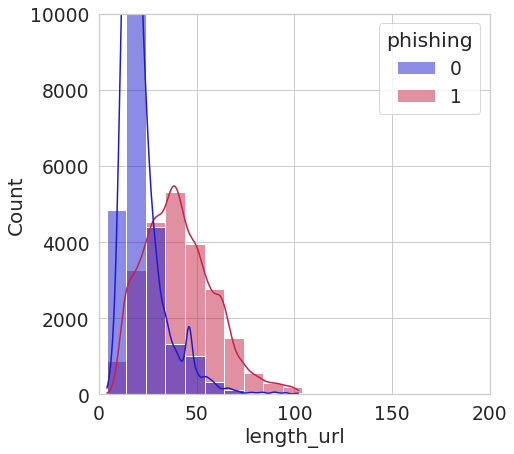

In [81]:

plt.figure(figsize=(7,7))
sns.histplot(data=ref_df, x="length_url", hue = "phishing",binwidth=10, kde=True, palette=sns.color_palette(colors))
plt.ylim(0,10000)
plt.xlim(0, 200)
plt.xlabel('length_url', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.show()

## We can clearly see that as the as the length of URL, Directory Length increases it is most likely to be a phishing website.

## Now we will calculate how the data is distributed among other features using bar graph.

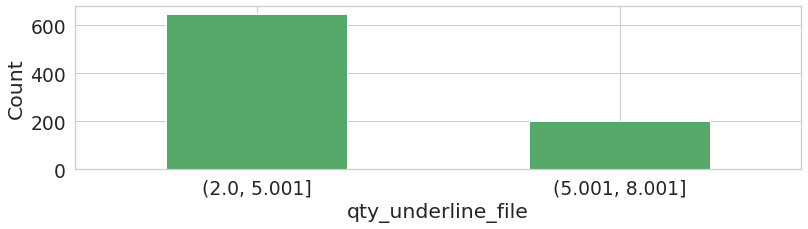

In [ ]:
 #bins = [0:max(ref_df.qty_hyphen_directory),100]
bins = np.arange(2.001,max(ref_df.qty_underline_file),3)
out = pd.cut(ref_df.qty_hyphen_directory,bins = bins,include_lowest= True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color = 'g', figsize=(13,3))
plt.xlabel('qty_underline_file')
plt.ylabel('Count')
plt.show()

# courses = list(data.keys())
# values = list(data.values())
# plt.bar(courses, values, color ='maroon', width = 0.4)

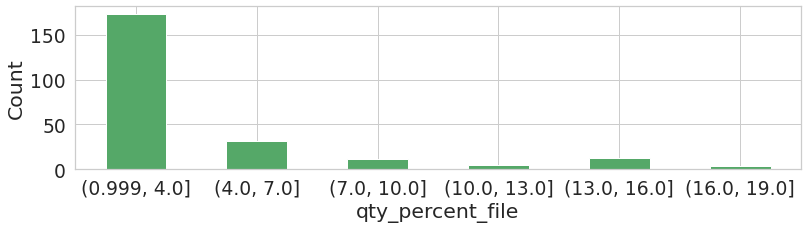

In [ ]:
 #bins = [0:max(ref_df.qty_hyphen_directory),100]
bins = np.arange(1,max(ref_df.qty_percent_file),3)
out = pd.cut(ref_df.qty_percent_file,bins = bins,include_lowest= True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color = 'g', figsize=(13,3))
plt.xlabel('qty_percent_file')
plt.ylabel('Count')
plt.show()

# courses = list(data.keys())
# values = list(data.values())
# plt.bar(courses, values, color ='maroon', width = 0.4)

## By the Below scatter plot we can see that the probability of URl is phishing if the value lies between 0 and 5 for the features qty_percent_file,qty_hyphen_directory

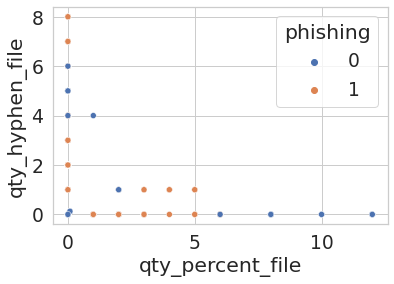

In [76]:
sns.scatterplot(data=ref_df, x="qty_percent_file", y="qty_hyphen_file", hue="phishing")

## By the Below scatter plot we can see that the probability of URl is phishing is more if the value lies between 0 and 2.5 for the features qty_percent_file,qty_hyphen_directory.

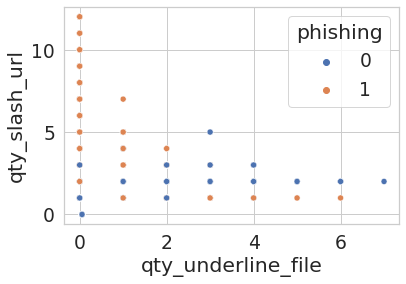

In [77]:
sns.scatterplot(data=ref_df, x="qty_underline_file", y="qty_slash_url", hue="phishing")

## Now let us train the mode to see how our cleaned dataset works using the KNN

In [62]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

X = imp_features_df
Y = ref_df['phishing']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_X = sc.fit_transform(train_X)
test_X = sc.transform(train_X)

In [64]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [67]:
# Predicting results using Test data set
pred = knn.predict(X_test)
from sklearn.metrics import accuracy_score
print('Accuracy: ',accuracy_score(pred,  y_test))
print('precision: ',precision_score(pred,  y_test))
print('recall: ',recall_score(pred,  y_test))
print('f1_score: ',f1_score(pred,  y_test))


Accuracy:  0.8961009435034671
precision:  0.907853516257967
recall:  0.8960443544087856
f1_score:  0.9019102811762182


In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, f1_score,precision_score, recall_score,confusion_matrix, accuracy_score

log_reg = LogisticRegression(C = 10, penalty='l1', solver='liblinear')
log_reg.fit(X_train, y_train)
print('Accuracy: ',round(accuracy_score(y_test,  log_reg.predict(X_test)), 3))
print('precision: ',round(precision_score(y_test,  log_reg.predict(X_test)), 3))
print('recall: ',round(recall_score(y_test,  log_reg.predict(X_test)), 3))
print('f1_score: ',round(f1_score(y_test,  log_reg.predict(X_test)), 3))

Accuracy:  0.856
precision:  0.866
recall:  0.86
f1_score:  0.863
